<a href="https://colab.research.google.com/github/timmyt110/Deep-Q-Learning-on-Atari-Final-Project/blob/main/Pong_DQNN_50k_ver2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Deep Q-Learning for Atari Pong - Project Implementation
# Improved version with realistic training parameters

# Install required packages
!pip install gymnasium[atari,accept-rom-license]
!pip install autorom
!pip install stable-baselines3
!pip install moviepy
!AutoROM --accept-license

import ale_py
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import collections
import typing as tt
from dataclasses import dataclass
import time
from datetime import datetime
import os
from google.colab import drive
from gymnasium.wrappers import RecordVideo
import matplotlib.pyplot as plt

# Mount Google Drive for saving models
drive.mount('/content/drive')

# Create save directories
save_dir_drive = "/content/drive/MyDrive/PUBLIC/Models_Final2"
save_dir_local = "saved_models"
os.makedirs(save_dir_drive, exist_ok=True)
os.makedirs(save_dir_local, exist_ok=True)

# Create save directory for videos in Google Drive
save_video_dir_drive = "/content/drive/MyDrive/PUBLIC/Videos_Final2"
os.makedirs(save_video_dir_drive, exist_ok=True)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.2/187.2 kB 5.8 MB/s eta 0:00:00
AutoROM will download the Atari 2600 ROMs.
They will be installed to:
	/usr/local/lib/python3.12/dist-packages/AutoROM/roms

Existing ROMs will be overwritten.
Installed /usr/local/lib/python3.12/dist-packages/AutoROM/roms/adventure.bin
Installed /usr/local/lib/python3.12/dist-packages/AutoROM/roms/air_raid.bin
Installed /usr/local/lib/python3.12/dist-packages/AutoROM/roms/alien.bin
Installed /usr/local/lib/python3.12/dist-packages/AutoROM/roms/amidar.bin
Installed /usr/local/lib/python3.12/dist-packages/AutoROM/roms/assault.bin
Installed /usr/local/lib/python3.12/dist-packages/AutoROM/roms/asterix.bin
Installed /usr/local/lib/python3.12/dist-packages/AutoROM/roms/asteroids.bin
Installed /usr/local/lib/python3.12/dist-packages/AutoROM/roms/atlantis.bin
Installed /usr/local/lib/python3.12/dist-packages/AutoROM/roms/atlantis2.bin
Installed /usr/local/lib/python3.12/dist-packages/AutoROM/roms/backgammon.bin
In

In [ ]:
# Hyperparameter
DEFAULT_ENV_NAME = "ALE/Pong-v5"

GAMMA = 0.99
BATCH_SIZE = 64
REPLAY_SIZE = 50000  # Larger buffer for better stability
LEARNING_RATE = .01
SYNC_TARGET_FRAMES = 1000
REPLAY_START_SIZE = 10000

# Epsilon schedule - MORE REALISTIC
EPSILON_START = 1.0
EPSILON_FINAL = 0.01
SAVE_EPSILON = 0.1  # Save on smaller improvements

# DEMO SETTINGS - Balanced for reasonable training time
DEMO_EPSILON_DECAY = 50000  # Train for 100k frames for demo
DEMO_MEAN_REWARD_BOUND = -10.0  # Stop if we reach -10 (shows clear learning)

In [ ]:
# NEURAL NETWORK MODELS
class DQN(nn.Module):
    """Baseline DQN network"""
    def __init__(self, input_shape, n_actions):
        super(DQN, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten()
        )

        # Calculate the size after conv layers
        with torch.no_grad():
            size = self.conv(torch.zeros(1, *input_shape)).size()[-1]

        self.fc = nn.Sequential(
            nn.Linear(size, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )

    def forward(self, x):
        x = x.float() / 255.0
        conv_out = self.conv(x)
        return self.fc(conv_out)


In [ ]:
# ENVIRONMENT WRAPPERS
from gymnasium import spaces
from stable_baselines3.common import atari_wrappers

class ImageToPyTorch(gym.ObservationWrapper):
    """Convert image from (H, W, C) to (C, H, W) for PyTorch"""
    def __init__(self, env):
        super(ImageToPyTorch, self).__init__(env)
        old_space = self.observation_space
        assert isinstance(old_space, spaces.Box)
        assert len(old_space.shape) == 3

        new_shape = (old_space.shape[-1], old_space.shape[0], old_space.shape[1])
        self.observation_space = spaces.Box(
            low=old_space.low.min(),
            high=old_space.high.max(),
            shape=new_shape,
            dtype=old_space.dtype
        )

    def observation(self, observation):
        return np.moveaxis(observation, 2, 0)

class BufferWrapper(gym.ObservationWrapper):
    """Stack n_steps frames together for temporal context"""
    def __init__(self, env, n_steps):
        super(BufferWrapper, self).__init__(env)
        self.n_steps = n_steps
        obs_space = env.observation_space

        self.observation_space = spaces.Box(
            low=obs_space.low.repeat(n_steps, axis=0),
            high=obs_space.high.repeat(n_steps, axis=0),
            dtype=obs_space.dtype
        )
        self.buffer = collections.deque(maxlen=n_steps)

    def reset(self, **kwargs):
        self.buffer.clear()
        obs, info = self.env.reset(**kwargs)
        for _ in range(self.n_steps):
            self.buffer.append(obs)
        return self.observation(obs), info

    def observation(self, observation):
        self.buffer.append(observation)
        return np.concatenate(self.buffer)

def make_env(env_name: str, n_steps=4, render_mode=None, **kwargs):
    """Create and wrap the environment"""
    env = gym.make(env_name, render_mode=render_mode, **kwargs)
    env = atari_wrappers.AtariWrapper(env, clip_reward=False, noop_max=0)
    env = ImageToPyTorch(env)
    env = BufferWrapper(env, n_steps=n_steps)
    return env


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
# EXPERIENCE REPLAY AND AGENT
@dataclass
class Experience:
    state: np.ndarray
    action: int
    reward: float
    done_trunc: bool
    new_state: np.ndarray

class ExperienceBuffer:
    """Experience replay buffer with uniform sampling"""
    def __init__(self, capacity: int):
        self.buffer = collections.deque(maxlen=capacity)

    def __len__(self):
        return len(self.buffer)

    def append(self, experience: Experience):
        self.buffer.append(experience)

    def sample(self, batch_size: int) -> tt.List[Experience]:
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        return [self.buffer[idx] for idx in indices]

class Agent:
    """DQN Agent with epsilon-greedy policy"""
    def __init__(self, env: gym.Env, exp_buffer: ExperienceBuffer):
        self.env = env
        self.exp_buffer = exp_buffer
        self.state = None
        self.total_reward = 0.0
        self._reset()

    def _reset(self):
        self.state, _ = self.env.reset()
        self.total_reward = 0.0

    @torch.no_grad()
    def play_step(self, net: DQN, device: torch.device, epsilon: float = 0.0) -> tt.Optional[float]:
        done_reward = None

        # Epsilon-greedy action selection
        if np.random.random() < epsilon:
            action = self.env.action_space.sample()  # Fixed: self.env
        else:
            state_v = torch.as_tensor(self.state).to(device).unsqueeze(0)
            q_vals_v = net(state_v)
            _, act_v = torch.max(q_vals_v, dim=1)
            action = int(act_v.item())

        # Environment step
        new_state, reward, is_done, is_tr, _ = self.env.step(action)
        self.total_reward += reward

        # Store experience
        exp = Experience(
            state=self.state,
            action=action,
            reward=float(reward),
            done_trunc=is_done or is_tr,
            new_state=new_state
        )
        self.exp_buffer.append(exp)
        self.state = new_state

        # Handle episode end
        if is_done or is_tr:
            done_reward = self.total_reward
            self._reset()

        return done_reward

In [ ]:
# UTILITY FUNCTIONS
def batch_to_tensors(batch: tt.List[Experience], device: torch.device):
    """Convert batch of experiences to tensors"""
    states, actions, rewards, dones, new_states = [], [], [], [], []

    for exp in batch:
        states.append(exp.state)
        actions.append(exp.action)
        rewards.append(exp.reward)
        dones.append(exp.done_trunc)
        new_states.append(exp.new_state)

    states_t = torch.as_tensor(np.array(states)).to(device)
    actions_t = torch.LongTensor(actions).to(device)
    rewards_t = torch.FloatTensor(rewards).to(device)
    dones_t = torch.BoolTensor(dones).to(device)
    new_states_t = torch.as_tensor(np.array(new_states)).to(device)

    return states_t, actions_t, rewards_t, dones_t, new_states_t

In [ ]:
# LOSS FUNCTIONS - BASELINE DQN AND DOUBLE DQN
def calc_loss_dqn(batch: tt.List[Experience], net: DQN, tgt_net: DQN, device: torch.device) -> torch.Tensor:
    """Baseline DQN loss (1-step TD with target network)"""
    states_t, actions_t, rewards_t, dones_t, new_states_t = batch_to_tensors(batch, device)

    # Current Q values for taken actions
    state_action_values = net(states_t).gather(1, actions_t.unsqueeze(-1)).squeeze(-1)

    # DQN target: max over target network
    with torch.no_grad():
        next_state_values = tgt_net(new_states_t).max(1)[0]
        next_state_values[dones_t] = 0.0
        expected_state_action_values = next_state_values * GAMMA + rewards_t

    return nn.MSELoss()(state_action_values, expected_state_action_values)

def calc_loss_double_dqn(batch: tt.List[Experience], net: DQN, tgt_net: DQN, device: torch.device) -> torch.Tensor:
    """Double DQN loss - decouples action selection from evaluation"""
    states_t, actions_t, rewards_t, dones_t, new_states_t = batch_to_tensors(batch, device)

    # Current Q values for taken actions
    state_action_values = net(states_t).gather(1, actions_t.unsqueeze(-1)).squeeze(-1)

    # Double DQN target: select with online net, evaluate with target net
    with torch.no_grad():
        next_actions = net(new_states_t).argmax(dim=1)  # Action selection with online net
        next_state_values = tgt_net(new_states_t).gather(1, next_actions.unsqueeze(-1)).squeeze(-1)
        next_state_values[dones_t] = 0.0
        expected_state_action_values = next_state_values * GAMMA + rewards_t

    return nn.MSELoss()(state_action_values, expected_state_action_values)

In [ ]:
# VIDEO RECORDING FUNCTIONS
def record_video(env_name: str, model: DQN, device: torch.device,
                 video_path: str, epsilon: float = 0.01, num_episodes: int = 1):
    """Record a video of the agent playing"""
    # Create environment with video recording
    env = make_env(env_name, render_mode='rgb_array')
    env = RecordVideo(env, video_path, episode_trigger=lambda x: True)

    agent = Agent(env, ExperienceBuffer(100))  # Small buffer for single episode

    for episode in range(num_episodes):
        done_reward = None
        while done_reward is None:
            done_reward = agent.play_step(model, device, epsilon)

    env.close()

def record_early_video(env_name: str, device: torch.device):
    """Record early random policy video"""
    print("Recording early (random) video...")
    model = DQN((4, 84, 84), 6).to(device)  # Random model
    video_dir = os.path.join(save_video_dir_drive, "early_video")
    os.makedirs(video_dir, exist_ok=True)
    record_video(env_name, model, device, video_dir, epsilon=1.0)
    print("✓ Early video recorded")

def record_later_video(env_name: str, model: DQN, device: torch.device, variant_name: str):
    """Record later trained policy video"""
    print(f"Recording later ({variant_name}) video...")
    video_dir = os.path.join(save_video_dir_drive, f"later_video_{variant_name}")
    os.makedirs(video_dir, exist_ok=True)
    record_video(env_name, model, device, video_dir, epsilon=0.01)
    print(f"✓ {variant_name} video recorded")

In [ ]:

# =============================================================================
# IMPROVED TRAINING FUNCTION WITH PROGRESS TRACKING
# =============================================================================
def train_with_progress_tracking(use_double_dqn=False, max_frames=DEMO_EPSILON_DECAY):
    """Train with better progress tracking and early stopping"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    env = make_env(DEFAULT_ENV_NAME)

    net = DQN(env.observation_space.shape, env.action_space.n).to(device)
    tgt_net = DQN(env.observation_space.shape, env.action_space.n).to(device)
    tgt_net.load_state_dict(net.state_dict())

    buffer = ExperienceBuffer(REPLAY_SIZE)
    agent = Agent(env, buffer)
    optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

    total_rewards = []
    frame_idx = 0
    epsilon = EPSILON_START
    best_m_reward = -float('inf')

    # Progress tracking
    start_time = time.time()
    last_log_time = start_time

    variant_name = "Double DQN" if use_double_dqn else "Baseline DQN"
    print(f"\n=== TRAINING {variant_name} ===")
    print("Frame | Mean Reward | Epsilon | Speed (f/s) | Time")
    print("-" * 60)

    # For plotting
    frame_indices = []
    mean_rewards = []

    while frame_idx < max_frames:
        frame_idx += 1
        epsilon = max(EPSILON_FINAL, EPSILON_START - frame_idx / max_frames)

        reward = agent.play_step(net, device, epsilon)

        if reward is not None:
            total_rewards.append(reward)

            # Log progress every 50 episodes or 30 seconds
            current_time = time.time()
            if len(total_rewards) % 50 == 0 or current_time - last_log_time > 30:
                m_reward = np.mean(total_rewards[-100:]) if len(total_rewards) >= 100 else np.mean(total_rewards)
                speed = frame_idx / (current_time - start_time)
                elapsed_min = (current_time - start_time) / 60

                print(f"{frame_idx:6d} | {m_reward:11.3f} | {epsilon:7.3f} | {speed:11.1f} | {elapsed_min:4.1f}m")

                # Store for plotting
                frame_indices.append(frame_idx)
                mean_rewards.append(m_reward)

                last_log_time = current_time

                # Save on improvement
                if m_reward > best_m_reward + SAVE_EPSILON:
                    best_m_reward = m_reward
                    timestamp = datetime.now().strftime("%Y%m%d-%H%M")
                    variant = "double" if use_double_dqn else "baseline"
                    model_filename = f"{variant}_dqn_best_{m_reward:.3f}_{timestamp}.dat"

                    model_path_drive = os.path.join(save_dir_drive, model_filename)
                    model_path_local = os.path.join(save_dir_local, model_filename)

                    torch.save(net.state_dict(), model_path_drive)
                    torch.save(net.state_dict(), model_path_local)

                    print(f"✓ Saved model with reward: {m_reward:.3f}")

            # Early stopping if we reach target
            if len(total_rewards) >= 100:
                m_reward = np.mean(total_rewards[-100:])
                if m_reward >= DEMO_MEAN_REWARD_BOUND:
                    print(f"🎯 Target reached! Mean reward: {m_reward:.3f}")
                    break

        # Training logic
        if len(buffer) >= REPLAY_START_SIZE:
            if frame_idx % SYNC_TARGET_FRAMES == 0:
                tgt_net.load_state_dict(net.state_dict())

            optimizer.zero_grad()
            batch = buffer.sample(BATCH_SIZE)

            if use_double_dqn:
                loss_t = calc_loss_double_dqn(batch, net, tgt_net, device)
            else:
                loss_t = calc_loss_dqn(batch, net, tgt_net, device)

            loss_t.backward()
            optimizer.step()

    env.close()

    # Create learning curve plot
    if frame_indices and mean_rewards:
        plt.figure(figsize=(10, 6))
        plt.plot(frame_indices, mean_rewards)
        plt.title(f'{variant_name} Learning Curve')
        plt.xlabel('Frames')
        plt.ylabel('Mean Reward (100-episode)')
        plt.grid(True)

        plot_filename = f"learning_curve_{'double' if use_double_dqn else 'baseline'}.png"
        plt.savefig(plot_filename)
        plt.close()
        print(f"✓ Learning curve saved as {plot_filename}")

    total_time = (time.time() - start_time) / 60
    print(f"Training completed in {total_time:.1f} minutes")
    print(f"Final mean reward: {np.mean(total_rewards[-100:]) if len(total_rewards) >= 100 else np.mean(total_rewards):.3f}")

    return net, total_rewards, frame_indices, mean_rewards

In [ ]:
# COMPARISON AND VISUALIZATION
def compare_algorithms(baseline_rewards, double_rewards, baseline_frames, double_frames):
    """Compare the learning curves of both algorithms"""
    plt.figure(figsize=(12, 8))

    if baseline_frames and baseline_rewards:
        plt.plot(baseline_frames, baseline_rewards, label='Baseline DQN', alpha=0.7)

    if double_frames and double_rewards:
        plt.plot(double_frames, double_rewards, label='Double DQN', alpha=0.7)

    plt.title('Comparison: Baseline DQN vs Double DQN')
    plt.xlabel('Frames')
    plt.ylabel('Mean Reward (100-episode)')
    plt.legend()
    plt.grid(True)
    plt.savefig('comparison_learning_curves.png')
    plt.show()


In [ ]:
# MAIN EXECUTION - DEMO TRAINING
def run_demo_training():
    """Run a complete demo training session"""
    print("Starting DQN Project for Atari Pong")
    print(f"Environment: {DEFAULT_ENV_NAME}")
    print(f"Device: {'cuda' if torch.cuda.is_available() else 'cpu'}")

    # Print hyperparameters
    print("\n=== HYPERPARAMETERS ===")
    print(f"GAMMA: {GAMMA}")
    print(f"BATCH_SIZE: {BATCH_SIZE}")
    print(f"REPLAY_SIZE: {REPLAY_SIZE}")
    print(f"LEARNING_RATE: {LEARNING_RATE}")
    print(f"SYNC_TARGET_FRAMES: {SYNC_TARGET_FRAMES}")
    print(f"REPLAY_START_SIZE: {REPLAY_START_SIZE}")
    print(f"EPSILON: {EPSILON_START} -> {EPSILON_FINAL}")
    print(f"MAX FRAMES: {DEMO_EPSILON_DECAY}")
    print(f"TARGET REWARD: {DEMO_MEAN_REWARD_BOUND}")

    # Record initial random policy
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    record_early_video(DEFAULT_ENV_NAME, device)

    # Train baseline DQN
    baseline_model, baseline_rewards, baseline_frames, baseline_means = train_with_progress_tracking(
        use_double_dqn=False,
        max_frames=DEMO_EPSILON_DECAY
    )

    # Train Double DQN
    double_dqn_model, double_rewards, double_frames, double_means = train_with_progress_tracking(
        use_double_dqn=True,
        max_frames=DEMO_EPSILON_DECAY
    )

    # Record final policies
    record_later_video(DEFAULT_ENV_NAME, baseline_model, device, "baseline")
    record_later_video(DEFAULT_ENV_NAME, double_dqn_model, device, "double")

    # Compare results
    compare_algorithms(baseline_means, double_means, baseline_frames, double_frames)

    print("\n=== TRAINING COMPLETE ===")
    print("Videos saved in '/content/drive/MyDrive/PUBLIC/Videos_Draft5' directories")
    print("Models saved to Google Drive and local directory")
    print("Learning curves saved as PNG files")

    return (baseline_model, double_dqn_model,
            baseline_rewards, double_rewards,
            baseline_frames, double_frames,
            baseline_means, double_means)


Starting DQN Project for Atari Pong
Environment: ALE/Pong-v5
Device: cpu

=== HYPERPARAMETERS ===
GAMMA: 0.99
BATCH_SIZE: 64
REPLAY_SIZE: 50000
LEARNING_RATE: 0.01
SYNC_TARGET_FRAMES: 1000
REPLAY_START_SIZE: 10000
EPSILON: 1.0 -> 0.01
MAX FRAMES: 50000
TARGET REWARD: -10.0
Recording early (random) video...


/usr/local/lib/python3.12/dist-packages/gymnasium/wrappers/rendering.py:293: UserWarning: WARN: Overwriting existing videos at /content/drive/MyDrive/PUBLIC/Videos_Final2/early_video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
/usr/local/lib/python3.12/dist-packages/moviepy/config_defaults.py:47: SyntaxWarning: invalid escape sequence '\P'
  IMAGEMAGICK_BINARY = r"C:\Program Files\ImageMagick-6.8.8-Q16\magick.exe"
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


✓ Early video recorded

=== TRAINING Baseline DQN ===
Frame | Mean Reward | Epsilon | Speed (f/s) | Time
------------------------------------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


 10240 |     -20.766 |   0.795 |       302.0 |  0.6m
✓ Saved model with reward: -20.766
 10871 |     -20.760 |   0.783 |       174.4 |  1.0m
 11527 |     -20.755 |   0.769 |       122.2 |  1.6m
 12260 |     -20.679 |   0.755 |        96.2 |  2.1m
 13097 |     -20.700 |   0.738 |        79.4 |  2.7m
 13923 |     -20.703 |   0.722 |        68.9 |  3.4m
 14752 |     -20.721 |   0.705 |        61.7 |  4.0m
 15430 |     -20.718 |   0.691 |        57.3 |  4.5m
 16249 |     -20.733 |   0.675 |        53.1 |  5.1m
 17093 |     -20.747 |   0.658 |        49.6 |  5.7m
 17770 |     -20.744 |   0.645 |        47.3 |  6.3m
 18618 |     -20.756 |   0.628 |        45.0 |  6.9m
 19437 |     -20.767 |   0.611 |        43.2 |  7.5m
 20291 |     -20.766 |   0.594 |        41.4 |  8.2m
 21193 |     -20.765 |   0.576 |        40.0 |  8.8m
 21626 |     -20.760 |   0.567 |        39.3 |  9.2m
 22440 |     -20.750 |   0.551 |        38.3 |  9.8m
 23272 |     -20.760 |   0.535 |        37.3 | 10.4m
 24129 |   

/usr/local/lib/python3.12/dist-packages/gymnasium/wrappers/rendering.py:293: UserWarning: WARN: Overwriting existing videos at /content/drive/MyDrive/PUBLIC/Videos_Final2/later_video_baseline folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


✓ baseline video recorded
Recording later (double) video...


/usr/local/lib/python3.12/dist-packages/gymnasium/wrappers/rendering.py:293: UserWarning: WARN: Overwriting existing videos at /content/drive/MyDrive/PUBLIC/Videos_Final2/later_video_double folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


✓ double video recorded


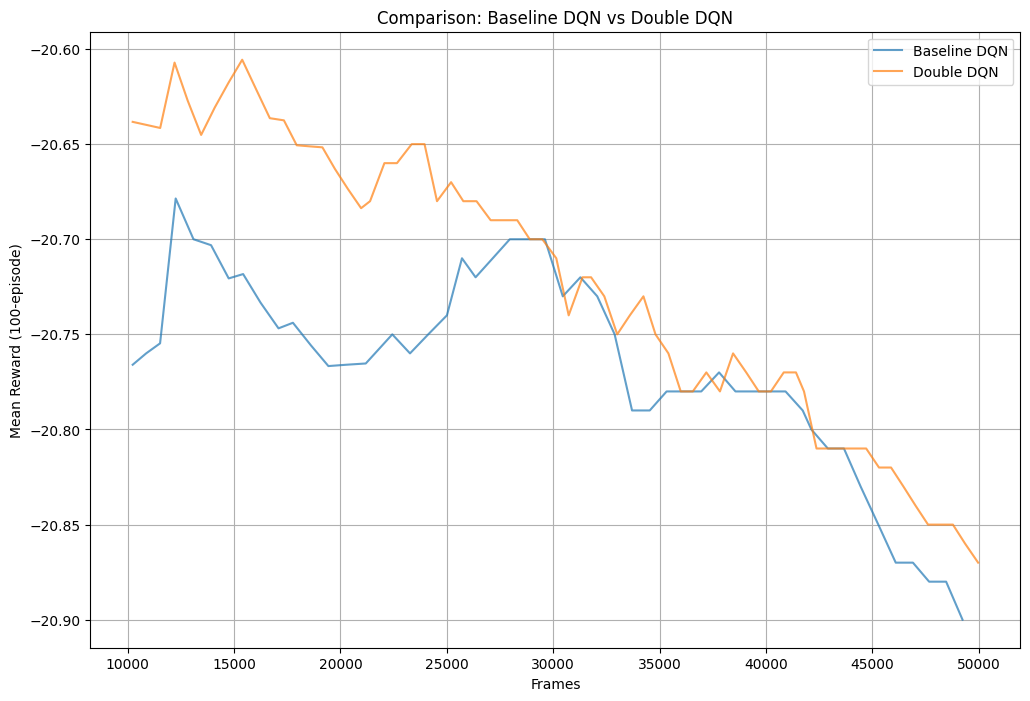


=== TRAINING COMPLETE ===
Videos saved in '/content/drive/MyDrive/PUBLIC/Videos_Draft5' directories
Models saved to Google Drive and local directory
Learning curves saved as PNG files

=== FINAL RESULTS ===
Baseline DQN Final Mean Reward: -20.890
Double DQN Final Mean Reward: -20.870
Double DQN improved performance by 0.1%


In [ ]:
# EXECUTE THE DEMO
if __name__ == "__main__":
    # Run the complete demo
    results = run_demo_training()

    # Summary
    baseline_final = np.mean(results[2][-100:]) if len(results[2]) >= 100 else np.mean(results[2])
    double_final = np.mean(results[3][-100:]) if len(results[3]) >= 100 else np.mean(results[3])

    print(f"\n=== FINAL RESULTS ===")
    print(f"Baseline DQN Final Mean Reward: {baseline_final:.3f}")
    print(f"Double DQN Final Mean Reward: {double_final:.3f}")

    if double_final > baseline_final:
        improvement = ((double_final - baseline_final) / abs(baseline_final)) * 100
        print(f"Double DQN improved performance by {improvement:.1f}%")